# Create a custom local circuit(Cirq Circuit) and run the custom circuit on a custom simulator(Cirq Simulator)

1. Install the required dependencies
2. Define CustomProgramContex inheriting the AbstractProgramContext
3. Map custom circuit gates to the openqasm interpreted string
4. Pass the CustomProgramContex to an interpreter and build the circuit
5. Run the custom circuit on custom simulator/device

## Setup for desired circuit

In this example, the `cirq` library is installed as a prerequisite.

In [1]:
!pip install cirq

In [2]:
from typing import List, Tuple, Optional

import cirq
import numpy as np
from braket.ir.jaqcd.program_v1 import Results
from cirq import Circuit as CirqCircuit

from translations import (
    CIRQ_GATES,
    CIRQ_NOISE_GATES,
    get_cirq_qubits,
)
from braket.default_simulator.openqasm.program_context import AbstractProgramContext
from braket.default_simulator.openqasm.interpreter import Interpreter

## Create a translations.py-like File for Gate Mapping

Map gates to Cirq gates

## Define ProgramContext

Inherit AbstractProgramContext and define the abstract methods

- The `AbstractProgramContext` class represents the context or state of an interpreter for a program. It provides a framework for managing symbols, variables, gates, subroutines, qubit mappings, and the circuit.


- The AbstractProgramContext class is an abstract base class (ABC) that defines the common structure and functionality expected in a program context. 

- It serves as a blueprint for creating concrete program contexts by defining a set of abstract methods and attributes that must be implemented by the subclasses. 

- Key attributes of the AbstractProgramContext include the symbol table, variable table, gate table, subroutine table, qubit mapping table, and the program circuit. 

- The circuit attribute represents the intermediate representation (IR) of the program that is built and handed off to the simulator or executor. 

- Various other methods, such as add_gate, get_gate_definition, is_user_defined_gate, add_subroutine, and get_subroutine_definition, enable gate and subroutine management within the program. 

- The AbstractProgramContext defines abstract methods for adding results, phase instructions, gate instructions, custom unitaries, and noise instructions to the program. 

In [3]:
class CirqProgramContext(AbstractProgramContext):
    def __init__(self, circuit: Optional[CirqCircuit] = None):
        """
        Args:
            circuit (Optional[Circuit]): A partially-built circuit to continue building with this
                context. Default: None.
        """
        super().__init__()
        self._circuit = circuit or CirqCircuit()

    @property
    def circuit(self) -> CirqCircuit:
        return self._circuit

    def is_builtin_gate(self, name: str) -> bool:
        """Whether the gate is currently in scope as a built-in Braket gate.

        Args:
            name (str): name of the built-in Braket gate

        Returns:
            bool: return TRUE if it is a built-in gate else FALSE.
        """
        user_defined_gate = self.is_user_defined_gate(name)
        return name in CIRQ_GATES and not user_defined_gate

    def add_gate_instruction(
            self, gate_name: str, target: Tuple[int], params, ctrl_modifiers: List[int], power: int
    ):
        """Add Braket gate to the circuit.

        Args:
            gate_name (str): name of the gate.
            target (Tuple[int]): control_qubits + target_qubits.
            ctrl_modifiers (List[int]): Quantum state on which to control the
                operation. Must be a binary sequence of same length as number of qubits in
                `control_qubits` in target. For example "0101", [0, 1, 0, 1], 5 all represent
                controlling on qubits 0 and 2 being in the \\|0⟩ state and qubits 1 and 3 being
                in the \\|1⟩ state.
            power(float): Integer or fractional power to raise the gate to.
        """
        qubits = get_cirq_qubits(target)
        target_cirq_qubits = qubits[len(ctrl_modifiers):]
        control_qubits = qubits[: len(ctrl_modifiers)]

        if params:
            gate = CIRQ_GATES[gate_name](*params).on(*target_cirq_qubits)
        else:
            gate = CIRQ_GATES[gate_name].on(*target_cirq_qubits)
        gate = gate.controlled_by(*control_qubits, control_values=ctrl_modifiers)
        gate = gate ** power

        self._circuit.append(gate)

    def add_custom_unitary(
            self,
            unitary: np.ndarray,
            target: Tuple[int],
    ) -> None:
        """Add a custom Unitary instruction to the circuit

        Args:
            unitary (np.ndarray): unitary matrix
            target (Tuple[int]): control_qubits + target_qubits
        """
        qubits = get_cirq_qubits(target)
        instruction = cirq.MatrixGate(unitary).on(*qubits)
        self._circuit.append(instruction)

    def add_noise_instruction(self, noise_instruction: str, target: List[int], probabilities: List[float]):
        """Method to add a noise instruction to the circuit

        Args:
            noise_instruction (str): The name of the noise operation
            target (List[int]): The target qubit or qubits to which the noise operation is applied.
            probabilities (List[float]): The probabilities associated with each possible outcome
                of the noise operation.
        """
        qubits = get_cirq_qubits(target)
        instruction = CIRQ_NOISE_GATES[noise_instruction](*probabilities).on(*qubits)
        self._circuit.append(instruction)

    def add_result(self, result: Results) -> None:
        """Add a result type to the circuit"""
        raise NotImplementedError
        
    def add_phase_instruction(self, target: Tuple[int], phase_value: int):
        raise NotImplementedError

## Basic gates example
This section showcases an example of basic gates. An OpenQASM program is defined, and a Circ circuit is built using the `Interpreter` and `CirqProgramContext` classes.

In [4]:
openqasm = """
            OPENQASM 3.0;
            bit[1] b;
            qubit[1] q;
            h q[0];
           """

basic_cirq_circuit = Interpreter(CirqProgramContext()).build_circuit(
        source=openqasm,
    )

basic_cirq_circuit.append(cirq.measure(*basic_cirq_circuit.all_qubits()))
print(basic_cirq_circuit)


0: ───H───M───


/var/folders/tb/2yh3yjmn3196046lsp7n2m5r0000gr/T/ipykernel_2558/2448392670.py:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if params:


## Running basic circuit on simulator

The simulator runs the circuit with a specified number of repetitions, and the results are displayed in a state histogram plot

q(0)=0010111011


/Users/spchit/workspace/amazon-braket-sdk-python/venv/lib/python3.9/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

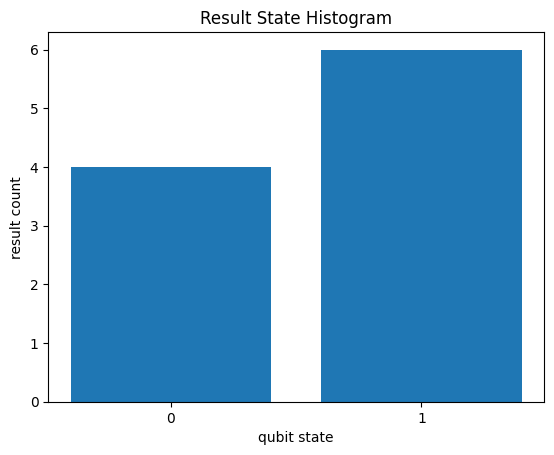

In [5]:
from cirq import plot_state_histogram as plt_hist

simulator = cirq.Simulator()

result = simulator.run(basic_cirq_circuit, repetitions=10)

print(result)
plt_hist(result)

## Noise Gate example

In [6]:
openqasm = """
            OPENQASM 3.0;
            bit[1] b;
            qubit[1] q;
            x q[0];
            #pragma braket noise bit_flip(0.1) q[0]
            b[0] = measure q[0];
            """
noise_cirq_circuit = Interpreter(CirqProgramContext()).build_circuit(
        source=openqasm,
    )
noise_cirq_circuit.append(cirq.measure(*basic_cirq_circuit.all_qubits()))
print(noise_cirq_circuit)

0: ───X───BF(0.1)───M───


/var/folders/tb/2yh3yjmn3196046lsp7n2m5r0000gr/T/ipykernel_2558/2448392670.py:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if params:


## Running noise circuits on cirq simulator

q(0)=1011111110101011111101111111111111011111111111111110111111101110111111011011111111111111111111111111


/Users/spchit/workspace/amazon-braket-sdk-python/venv/lib/python3.9/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

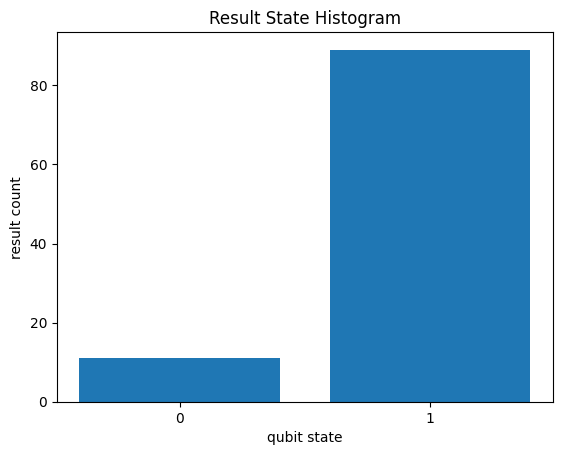

In [7]:
from cirq import plot_state_histogram as plt_hist

result = simulator.run(noise_cirq_circuit, repetitions=100)

print(result)
plt_hist(result)

## Instructions to add a cirq as one of the local simulators in Braket Simulators.

This section provides instructions for adding Cirq as a local simulator in Braket Simulators. It includes defining a `CirqSimulator` class, and implementing necessary methods for initialization, circuit execution, and result generation.

In [8]:
import sys
import uuid

import cirq
from braket.device_schema.simulators import (
    GateModelSimulatorDeviceCapabilities,
    GateModelSimulatorDeviceParameters,
)
from braket.ir.openqasm import Program as OpenQASMProgram
from braket.task_result import GateModelTaskResult, TaskMetadata, AdditionalMetadata
from cirq import Simulator


from braket.default_simulator.openqasm.interpreter import Interpreter
from braket.default_simulator.simulator import OpenQASMSimulator
from braket.default_simulator.local_execution_manager import LocalExecutionManager


class CirqSimulator(OpenQASMSimulator):
    DEVICE_ID = "cirq"

    def initialize_simulation(self):
        """
        Initialize cirq simulation.


        Returns:
            cirq.Simulator: Initialized simulation.
        """
        return Simulator()

    def run(self, circuit_ir: OpenQASMProgram, shots, *args, **kwargs):
        circuit = self.parse_program(circuit_ir).circuit
        circuit.append(cirq.measure(*circuit.all_qubits()))
        simulation = self.initialize_simulation()
        result = simulation.run(circuit, repetitions=shots)
        return self._create_results_obj(circuit_ir, result)
    
    def execution_manager(self, *args, **kwargs) -> LocalExecutionManager:
        return LocalExecutionManager(self, *args, **kwargs)
    
    def create_program_context(self) -> CirqProgramContext:
        return CirqProgramContext()

    def _get_measured_qubits(self, result):
        measured_qubits = set()
        for key in result.measurements.keys():
            measured_qubits.update([qubit[qubit.index("(") + 1 : -1] for qubit in key.split(",")])
        return list(measured_qubits)

    def _create_results_obj(
        self,
        circuit_ir: OpenQASMProgram,
        result: cirq.Result,
    ) -> GateModelTaskResult:
        return GateModelTaskResult.construct(
            taskMetadata=TaskMetadata(
                id=str(uuid.uuid4()),
                shots=result.repetitions,
                deviceId=self.DEVICE_ID,
            ),
            additionalMetadata=AdditionalMetadata(
                action=circuit_ir,
            ),
            measurements=list(list(result.measurements.values())[0]),
            measuredQubits=self._get_measured_qubits(result),
        )

    @property
    def properties(self):
        max_shots = sys.maxsize
        return GateModelSimulatorDeviceCapabilities.parse_obj(
            {
                "service": {
                    "executionWindows": [
                        {
                            "executionDay": "Everyday",
                            "windowStartHour": "00:00",
                            "windowEndHour": "23:59:59",
                        }
                    ],
                    "shotsRange": [0, max_shots],
                },
                "action": {
                    "braket.ir.openqasm.program": {
                        "actionType": "braket.ir.openqasm.program",
                        "version": ["1"],
                        "supportedOperations": [
                            # builtin Braket gates
                            "ccnot",
                            "cnot",
                            "cphaseshift",
                            "cswap",
                            "h",
                            "i",
                            "iswap",
                            "rx",
                            "ry",
                            "rz",
                            "s",
                            "swap",
                            "t",
                            "x",
                            "y",
                            "z",
                        ],
                        "supportedModifiers": [
                            {
                                "name": "ctrl",
                            },
                            {
                                "name": "negctrl",
                            },
                            {
                                "name": "pow",
                                "exponent_types": ["int", "float"],
                            },
                            {
                                "name": "inv",
                            },
                        ],
                        "supportedPragmas": [
                            "braket_unitary_matrix",
                            "braket_result_type_state_vector",
                            "braket_result_type_density_matrix",
                            "braket_result_type_sample",
                            "braket_result_type_expectation",
                            "braket_result_type_variance",
                            "braket_result_type_probability",
                            "braket_result_type_amplitude",
                            "braket_noise_bit_flip",
                            "braket_noise_depolarizing",
                            "braket_noise_generalized_amplitude_damping",
                            "braket_noise_phase_flip",
                            "braket_noise_phase_damping",
                        ],
                        "forbiddenPragmas": [
                            "braket_noise_amplitude_damping",
                            "braket_noise_kraus",
                            "braket_noise_pauli_channel",
                            "braket_noise_two_qubit_dephasing",
                            "braket_noise_two_qubit_depolarizing",
                            "braket_result_type_adjoint_gradient",
                        ],
                        "supportPhysicalQubits": False,
                        "supportsPartialVerbatimBox": False,
                        "requiresContiguousQubitIndices": True,
                        "requiresAllQubitsMeasurement": True,
                        "supportsUnassignedMeasurements": True,
                        "disabledQubitRewiringSupported": False,
                    },
                },
                "paradigm": {"qubitCount": 20},
                "deviceParameters": GateModelSimulatorDeviceParameters.schema(),
            }
        )

### Running a braket circuit on the local simulator defined above

In [9]:
from braket.circuits import Circuit
from braket.circuits.serialization import IRType
from braket.devices import LocalSimulator

dev = LocalSimulator(CirqSimulator())
braket_circuit = Circuit().h(0)
openqasm_program = braket_circuit.to_ir(IRType.OPENQASM)
result = dev.run(openqasm_program, shots=10).result()
print("Result", result)

Result GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='c51d37e0-315c-4e66-87d3-910329f76cf6', shots=10, deviceId='cirq', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='OPENQASM 3.0;\nbit[1] b;\nqubit[1] q;\nh q[0];\nb[0] = measure q[0];', inputs={}), dwaveMetadata=None, ionqMetadata=None, rigettiMetadata=None, oqcMetadata=None, xanaduMetadata=None, queraMetadata=None, simulatorMetadata=None), result_types=[], values=[], measurements=array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]]), measured_qubits=['0'], measurement_counts=Counter({'1': 7, '0': 3}), measurement_probabilities={'0': 0.3, '1': 0.7}, measurements_copied_from_device=

/var/folders/tb/2yh3yjmn3196046lsp7n2m5r0000gr/T/ipykernel_2558/2448392670.py:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if params:


## Add Cirq Ionq as device using the program context and task execution manager

In [10]:
!pip install cirq_ionq

In [12]:
from typing import Union
from braket.simulator.quantum_task import ExecutionManager
import cirq_ionq

class CirqIonqExecutionManager(ExecutionManager):
    """Execution manager for running Cirq programs on IonQ devices.
    
    This class provides functionality to manage the execution of Cirq programs on IonQ quantum devices.
    It handles circuit creation, execution, and result retrieval, as well as providing methods to
    interact with the executed task.
    
    Args:
        device (IonQDevice): An instance of the IonQ quantum device on which to run the program.
        program (str): The OpenQASM program to be executed on the device.
        shots (int): The number of times the circuit should be executed.
        *args: Additional positional arguments passed to the device creation function.
        **kwargs: Additional keyword arguments passed to the device creation function.
    """

    def __init__(self, device, program, shots ,*args, **kwargs):
        """Initialize the execution manager with the provided device, program, and shot count."""
        circuit = device.parse_program(program).circuit
        circuit.append(cirq.measure(*circuit.all_qubits()))
        self.job = device.create(circuit, repetitions=shots, *args, **kwargs)
        self.program = program
        self.device = device

    def result(
            self,
    ) -> GateModelTaskResult:
        """Retrieve the results of the quantum execution.
    
        Returns:
            GateModelTaskResult: The results of the quantum execution, including metadata and measurements.
        """
        result = self.job.results().to_cirq_result()
        return self._create_results_obj(self.program, result)

    def cancel(self) -> None:
        """Cancel the quantum task.
        
        Cancels the ongoing quantum execution on the IonQ device.
        """
        self.job.cancel()

    def state(self) -> str:
        """Get the current state of the quantum task.
        
        Returns:
            str: The current state of the quantum task, e.g. 'completed', 'canceled', 'failed', 'deleted', 'ready', 'submitted', 'running'.
        """
        return self.job.status()

    
    def _get_measured_qubits(self, result):
        measured_qubits = set()
        for key in result.measurements.keys():
            measured_qubits.update([qubit[qubit.index("(") + 1 : -1] for qubit in key.split(",")])
        return list(measured_qubits)

    def _create_results_obj(
        self,
        circuit_ir: OpenQASMProgram,
        result: cirq.Result,
    ) -> GateModelTaskResult:
        """Create a task result object from the execution results.
        
        Args:
            circuit_ir (OpenQASMProgram): The original OpenQASM program executed.
            result (cirq.Result): The execution result containing measurements.
            
        Returns:
            GateModelTaskResult: A constructed task result object containing metadata and measurements.
        """
        return GateModelTaskResult.construct(
            taskMetadata=TaskMetadata(
                id=str(uuid.uuid4()),
                shots=result.repetitions,
                deviceId=self.device.DEVICE_ID,
            ),
            additionalMetadata=AdditionalMetadata(
                action=circuit_ir,
            ),
            measurements=list(list(result.measurements.values())[0]),
            measuredQubits=self._get_measured_qubits(result),
        )

In [13]:
import sys
import uuid
import os

import cirq
from braket.device_schema.simulators import (
    GateModelSimulatorDeviceCapabilities,
    GateModelSimulatorDeviceParameters,
)
from braket.ir.openqasm import Program as OpenQASMProgram
from braket.task_result import GateModelTaskResult, TaskMetadata, AdditionalMetadata
from cirq import Simulator


from braket.default_simulator.openqasm.interpreter import Interpreter
from braket.default_simulator.simulator import OpenQASMSimulator
from braket.default_simulator.local_execution_manager import LocalExecutionManager


class CirqIonqDevice(OpenQASMSimulator):
    DEVICE_ID = "CirqIonqDevice"
    SERVICE = cirq_ionq.Service(api_key=os.environ.get('CIRQ_IONQ_APIKEY'))
    def create(self, circuit, *args, **kwargs):
        return self.SERVICE.create_job(circuit, *args, **kwargs)

    def run(self):
        # Since it runs on quantum computer
        pass

    def execution_manager(self, *args, **kwargs) -> LocalExecutionManager:
        return CirqIonqExecutionManager(self, *args, **kwargs)

    def create_program_context(self) -> CirqProgramContext:
        return CirqProgramContext()

    @property
    def properties(self):
        max_shots = sys.maxsize
        return GateModelSimulatorDeviceCapabilities.parse_obj(
            {
                "service": {
                    "executionWindows": [
                        {
                            "executionDay": "Everyday",
                            "windowStartHour": "00:00",
                            "windowEndHour": "23:59:59",
                        }
                    ],
                    "shotsRange": [0, max_shots],
                },
                "action": {
                    "braket.ir.openqasm.program": {
                        "actionType": "braket.ir.openqasm.program",
                        "version": ["1"],
                        "supportedOperations": [
                            # builtin Braket gates
                            "ccnot",
                            "cnot",
                            "cphaseshift",
                            "cswap",
                            "h",
                            "i",
                            "iswap",
                            "rx",
                            "ry",
                            "rz",
                            "s",
                            "swap",
                            "t",
                            "x",
                            "y",
                            "z",
                        ],
                        "supportedModifiers": [
                            {
                                "name": "ctrl",
                            },
                            {
                                "name": "negctrl",
                            },
                            {
                                "name": "pow",
                                "exponent_types": ["int", "float"],
                            },
                            {
                                "name": "inv",
                            },
                        ],
                        "supportedPragmas": [
                            "braket_unitary_matrix",
                            "braket_result_type_state_vector",
                            "braket_result_type_density_matrix",
                            "braket_result_type_sample",
                            "braket_result_type_expectation",
                            "braket_result_type_variance",
                            "braket_result_type_probability",
                            "braket_result_type_amplitude",
                            "braket_noise_bit_flip",
                            "braket_noise_depolarizing",
                            "braket_noise_generalized_amplitude_damping",
                            "braket_noise_phase_flip",
                            "braket_noise_phase_damping",
                        ],
                        "forbiddenPragmas": [
                            "braket_noise_amplitude_damping",
                            "braket_noise_kraus",
                            "braket_noise_pauli_channel",
                            "braket_noise_two_qubit_dephasing",
                            "braket_noise_two_qubit_depolarizing",
                            "braket_result_type_adjoint_gradient",
                        ],
                        "supportPhysicalQubits": False,
                        "supportsPartialVerbatimBox": False,
                        "requiresContiguousQubitIndices": True,
                        "requiresAllQubitsMeasurement": True,
                        "supportsUnassignedMeasurements": True,
                        "disabledQubitRewiringSupported": False,
                    },
                },
                "paradigm": {"qubitCount": 20},
                "deviceParameters": GateModelSimulatorDeviceParameters.schema(),
            }
        )

### Quantum Program Execution Using Braket and Cirq IonQ

This code demonstrates how to create and execute a quantum program using the Braket library in conjunction with Cirq IonQ. Here is a breakdown of the steps:

1. **Importing Dependencies**: The necessary classes and functions from the Braket library are imported, including `Program`  for defining quantum programs, `BraketSchemaHeader` for schema information, `LocalSimulator` for running simulations locally and `CirqIonqDevice` for interfacing with Cirq IonQ devices.

2. **Creating a Local Simulator**: An instance of the `LocalSimulator` is created and then the `CirqIonqDevice` is specified as the device to be used for running the quantum program.

3. **Defining the Quantum Program**: A `Program` is defined using the OpenQASM 3.0 syntax. This program consists of a single qubit (denoted as `q`) that undergoes an X-gate (`x q[0]`) and a Hadamard gate (`h q[0]`). The measurement outcome is stored in a classical bit (`b[0] = measure q[0]`).

4. **Running the Quantum Program**: The defined quantum program is executed on the local simulator (`sim.run()`). The `shots` parameter specifies the number of times the circuit is executed (100 shots in this case). The `target` parameter specifies the simulation target, which is the "simulator" in this example.

5. **Result Handling**: The execution of the program results in a `task` object, which represents the execution task. Further actions can be taken on this task, such as retrieving the execution results or analyzing the outcomes.


In [14]:
from braket.ir.openqasm import Program
from braket.schema_common import BraketSchemaHeader


sim = LocalSimulator(CirqIonqDevice())

program = Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source="""
            OPENQASM 3.0;
            bit[1] b;
            qubit[1] q;
            x q[0];
            h q[0];
            b[0] = measure q[0];
            """, inputs={})
task = sim.run(program,shots=100, target ="simulator")

/var/folders/tb/2yh3yjmn3196046lsp7n2m5r0000gr/T/ipykernel_2558/2448392670.py:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if params:


In [15]:
print(task)
print(task.state())

ready


In [16]:
print(task.result())

GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='5d7b1b83-d29e-44a9-84ab-6d1a9ed6931f', shots=100, deviceId='CirqIonqDevice', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='\n            OPENQASM 3.0;\n            bit[1] b;\n            qubit[1] q;\n            x q[0];\n            h q[0];\n            b[0] = measure q[0];\n            ', inputs={}), dwaveMetadata=None, ionqMetadata=None, rigettiMetadata=None, oqcMetadata=None, xanaduMetadata=None, queraMetadata=None, simulatorMetadata=None), result_types=[], values=[], measurements=array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
  